In [1]:
# To clean enviroment variables 
%reset

## Classical Solution

In [2]:
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt

try:
    import cplex
    from cplex.exceptions import CplexError
except:
    print("Warning: Cplex not found.")
import math

from qiskit.utils import algorithm_globals
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import SPSA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler

### Clean dataset

In [4]:
df = pd.read_csv("uscities.csv")
columnsNeeded = ["city", "lat", "lng"]
# Inicialization of variables
locationsNumber = 15 # OJO que en local me crashea si sobrepaso 5

coordenatesDf = df[columnsNeeded].iloc[:locationsNumber]
n = coordenatesDf.shape[0]  # number of nodes + depot (n+1)
K = 3  # number of vehicles

print(coordenatesDf)

             city      lat       lng
0        New York  40.6943  -73.9249
1     Los Angeles  34.1139 -118.4068
2         Chicago  41.8373  -87.6862
3           Miami  25.7839  -80.2102
4          Dallas  32.7936  -96.7662
5    Philadelphia  40.0077  -75.1339
6         Houston  29.7863  -95.3889
7         Atlanta  33.7627  -84.4224
8      Washington  38.9047  -77.0163
9          Boston  42.3188  -71.0846
10        Phoenix  33.5722 -112.0891
11        Seattle  47.6211 -122.3244
12  San Francisco  37.7562 -122.4430
13        Detroit  42.3834  -83.1024
14      San Diego  32.8312 -117.1225


In [5]:
# Initialize instance values by calculate the squared Euclidean distances between a set of coordinates
#  represented in the dataframe.

def generate_instance(coordenatesDf):
    n = coordenatesDf.shape[0]
    
    xc = coordenatesDf["lat"]
    yc = coordenatesDf["lng"]
    loc = coordenatesDf["city"]
    instance = np.zeros([n, n])
    for ii in range(0, n):
        for jj in range(ii + 1, n):
            instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
            instance[jj, ii] = instance[ii, jj]
    return xc, yc, instance, loc

In [6]:
# Initialize the problem by randomly generating the instance
lat, lng, instance, loc = generate_instance(coordenatesDf)

print(lat, lng, loc, instance)

0     40.6943
1     34.1139
2     41.8373
3     25.7839
4     32.7936
5     40.0077
6     29.7863
7     33.7627
8     38.9047
9     42.3188
10    33.5722
11    47.6211
12    37.7562
13    42.3834
14    32.8312
Name: lat, dtype: float64 0     -73.9249
1    -118.4068
2     -87.6862
3     -80.2102
4     -96.7662
5     -75.1339
6     -95.3889
7     -84.4224
8     -77.0163
9     -71.0846
10   -112.0891
11   -122.3244
12   -122.4430
13    -83.1024
14   -117.1225
Name: lng, dtype: float64 0          New York
1       Los Angeles
2           Chicago
3             Miami
4            Dallas
5      Philadelphia
6           Houston
7           Atlanta
8        Washington
9            Boston
10          Phoenix
11          Seattle
12    San Francisco
13          Detroit
14        San Diego
Name: city, dtype: object [[0.00000000e+00 2.02194109e+03 1.90679827e+02 2.61825024e+02
  5.84146046e+02 1.93310056e+00 5.79687760e+02 1.58244585e+02
  1.27594221e+01 1.07063043e+01 1.50723047e+03 2.39049216e+03
 

In [211]:
#print(instance)

### -------------------- Classical solution using IBM ILOG CPLEX --------------------

In [7]:
class ClassicalOptimizer:
    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles

    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n - self.K)

    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0]) + [0.0 for x in range(0, n - 1)]
        my_ub = [1 for x in range(0, n**2 + n - 1)]
        my_lb = [0 for x in range(0, n**2)] + [0.1 for x in range(0, n - 1)]
        my_ctype = "".join(["I" for x in range(0, n**2)]) + "".join(
            ["C" for x in range(0, n - 1)]
        )

        my_rhs = (
            2 * ([K] + [1 for x in range(0, n - 1)])
            + [1 - 0.1 for x in range(0, (n - 1) ** 2 - (n - 1))]
            + [0 for x in range(0, n)]
        )
        my_sense = (
            "".join(["E" for x in range(0, 2 * n)])
            + "".join(["L" for x in range(0, (n - 1) ** 2 - (n - 1))])
            + "".join(["E" for x in range(0, n)])
        )

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x, cost

    def populatebyrow(self, prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs):

        n = self.n

        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_ctype)

        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0, n):
            col = [x for x in range(0 + n * ii, n + n * ii)]
            coef = [1 for x in range(0, n)]
            rows.append([col, coef])

        for ii in range(0, n):
            col = [x for x in range(0 + ii, n**2, n)]
            coef = [1 for x in range(0, n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0, n):
                if (ii != jj) and (ii * jj > 0):

                    col = [ii + (jj * n), n**2 + ii - 1, n**2 + jj - 1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0, n):
            col = [(ii) * (n + 1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)


In [8]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance, n, K)

In [9]:
# Print number of feasible solutions
print("Number of feasible solutions = " + str(classical_optimizer.compute_allowed_combinations()))


Number of feasible solutions = 455.0


In [10]:
# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x, classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii // n != ii % n]
    # Print the solution
    print(z)
except:
    print("CPLEX may be missing.")


[-0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, 1.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, 0.0, -0.0, 0.0, 1.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 1.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 1.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0

In [11]:
m = folium.Map(location=[39.487660, -97.594333], zoom_start=0)
marker_icon1 = folium.Icon(color = "red")
for i in range(len(lat)):
    if (i == 0):
        folium.Marker(location=[lat[i], lng[i]], tooltip=f"Location: {loc[i]}, Order: {i}", icon=marker_icon1).add_to(m)
    else:
        folium.Marker(location=[lat[i], lng[i]], tooltip=f"Location: {loc[i]}, Order: {i}").add_to(m)

for ii in range(0, n**2):
    if x[ii] > 0:
        ix = ii // n
        iy = ii % n
        
        folium.PolyLine([(lat[ix], lng[ix]), (lat[iy], lng[iy])], color="blue").add_to(m)

m

## Quantum Solution

In [217]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver

In [218]:
class QuantumOptimizer:
    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n
        self.K = K

    def binary_representation(self, x_sol=0):

        instance = self.instance
        n = self.n
        K = self.K

        A = np.max(instance) * 100  # A parameter of cost function

        # Determine the weights w
        instance_vec = instance.reshape(n**2)
        w_list = [instance_vec[x] for x in range(n**2) if instance_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for ii in range(len(w_list)):
            w[ii] = w_list[ii]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n - 1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n * (n - 1)])
        for ii in range(n):
            count = ii - 1
            for jj in range(n * (n - 1)):

                if jj // (n - 1) == ii:
                    count = ii

                if jj // (n - 1) != ii and jj % (n - 1) == count:
                    v[ii][jj] = 1.0

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A * (np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = (
            w
            - 2 * A * (np.kron(Iv_n_1, Iv_n) + vn.T)
            - 2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)
        )

        # c is the constant offset
        c = 2 * A * (n - 1) + 2 * A * (K**2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = (
                lambda x: np.dot(np.around(x), np.dot(Q, np.around(x)))
                + np.dot(g, np.around(x))
                + c
            )
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        qp = QuadraticProgram()
        for i in range(n * (n - 1)):
            qp.binary_var(str(i))
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c
        return qp

    def solve_problem(self, qp):
        algorithm_globals.random_seed = 10598
        #vqe = SamplingVQE(sampler=Sampler(), optimizer=SPSA(), ansatz=RealAmplitudes())
        #optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe)

        meo = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
        result = meo.solve(qp)

        # compute cost of the obtained result
        _, _, _, level = self.binary_representation(x_sol=result.x)
        return result.x, level

In [219]:
# Instantiate the quantum optimizer class with parameters:
quantum_optimizer = QuantumOptimizer(instance, n, K)

In [220]:
# Check if the binary representation is correct
try:
    if z is not None:
        Q, g, c, binary_cost = quantum_optimizer.binary_representation(x_sol=z)
        print("Binary cost:", binary_cost, "classical cost:", classical_cost)
        if np.abs(binary_cost - classical_cost) < 0.01:
            print("Binary formulation is correct")
        else:
            print("Error in the binary formulation")
    else:
        print("Could not verify the correctness, due to CPLEX solution being unavailable.")
        Q, g, c, binary_cost = quantum_optimizer.binary_representation()
        print("Binary cost:", binary_cost)
except NameError as e:
    print("Warning: Please run the cells above first.")
    print(e)

Binary cost: 3981.1556002814323 classical cost: 3981.1556002800016
Binary formulation is correct


In [221]:
qp = quantum_optimizer.construct_problem(Q, g, c)
print(qp)

minimize 404388.2183540002*0^2 + 404388.2183540002*0*1 + 404388.2183540002*0*13 + 404388.2183540002*0*17 + 404388.2183540002*0*2 + 404388.2183540002*0*3 + 404388.2183540002*0*9 + 404388.2183540002*1^2 + 404388.2183540002*1*14 + 404388.2183540002*1*18 + 404388.2183540002*1*2 + 404388.2183540002*1*3 + 404388.2183540002*1*5 + 404388.2183540002*10^2 + 404388.2183540002*10*11 + 404388.2183540002*10*19 + 404388.2183540002*11^2 + 404388.2183540002*11*15 + 404388.2183540002*12^2 + 404388.2183540002*12*13 + 404388.2183540002*12*14 + 404388.2183540002*12*15 + 404388.2183540002*12*16 + 404388.2183540002*13^2 + 404388.2183540002*13*14 + 404388.2183540002*13*15 + 404388.2183540002*13*17 + 404388.2183540002*14^2 + 404388.2183540002*14*15 + 404388.2183540002*14*18 + 404388.2183540002*15^2 + 404388.2183540002*16^2 + 404388.2183540002*16*17 + 404388.2183540002*16*18 + 404388.2183540002*16*19 + 404388.2183540002*17^2 + 404388.2183540002*17*18 + 404388.2183540002*17*19 + 404388.2183540002*18^2 + 404388.2

In [222]:
#quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp)
quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp)

print(quantum_solution, quantum_cost)

[0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.] 3981.155600280501


## Visualize Results

### Classical Result:

In [223]:
print(classical_cost)

3981.1556002800016


In [224]:
m = folium.Map(location=[39.487660, -97.594333], zoom_start=0)
marker_icon1 = folium.Icon(color = "red")
for i in range(len(lat)):
    if (i == 0):
        folium.Marker(location=[lat[i], lng[i]], tooltip=f"Location: {loc[i]}, Order: {i}", icon=marker_icon1).add_to(m)
    else:
        folium.Marker(location=[lat[i], lng[i]], tooltip=f"Location: {loc[i]}, Order: {i}").add_to(m)

for ii in range(0, n**2):
    if x[ii] > 0:
        ix = ii // n
        iy = ii % n
        
        folium.PolyLine([(lat[ix], lng[ix]), (lat[iy], lng[iy])], color="blue").add_to(m)

m


### Quantum Result: 

In [225]:
print(quantum_cost)

3981.155600280501


In [226]:
x_quantum = np.zeros(n**2)
kk = 0

for ii in range(n**2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution[kk]
        kk += 1

m = folium.Map(location=[39.487660, -97.594333], zoom_start=0)
marker_icon1 = folium.Icon(color = "red")
for i in range(len(lat)):
    if (i == 0):
        folium.Marker(location=[lat[i], lng[i]], tooltip=f"Location: {loc[i]}, Order: {i}", icon=marker_icon1).add_to(m)
    else:
        folium.Marker(location=[lat[i], lng[i]], tooltip=f"Location: {loc[i]}, Order: {i}").add_to(m)

for ii in range(0, n**2):
    if x_quantum[ii] > 0:
        ix = ii // n
        iy = ii % n
        
        folium.PolyLine([(lat[ix], lng[ix]), (lat[iy], lng[iy])], color="blue").add_to(m)

m

## Results

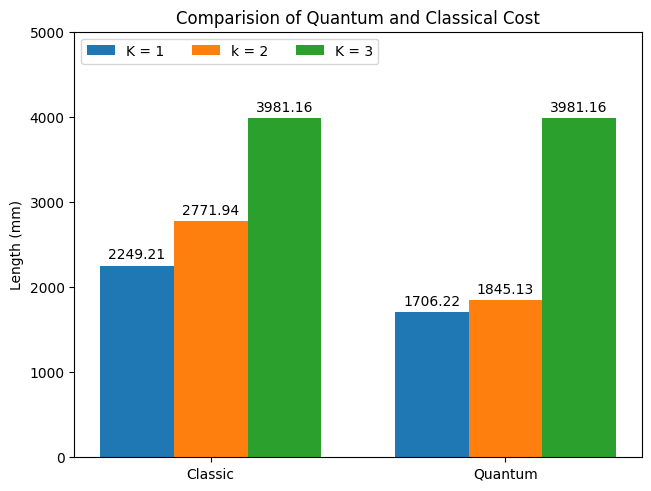

In [227]:
algorithms = ("Classic", "Quantum")
data = {
    'K = 1': (2249.2068134000006, 1706.2245994000696),
    'k = 2': (2771.940853740001, 1845.127222779207),
    'K = 3': (3981.1556002800016, 3981.155600280501),
}

x = np.arange(len(algorithms))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Comparision of Quantum and Classical Cost')
ax.set_xticks(x + width, algorithms)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 5000)

plt.show()